In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("../data/sample_20210509.sqlite")

In [19]:
pd.read_sql_query("select * from levels", conn)

,index,name,level,timestamp
0,0,Unlucky,200,2016-08-07T16:27:09
1,1,Unlucky,199,2016-07-24T12:45:27
2,2,Unlucky,198,2016-07-14T07:50:14
3,3,Unlucky,197,2016-06-24T00:51:22
4,4,Unlucky,196,2016-06-09T07:10:15
...,...,...,...,...
78378,78378,Lawkes,2,2021-04-15T18:44:22
78379,78379,Troyy,2,2021-04-24T07:52:33
78380,78380,Liridas,2,2021-04-26T21:29:08
78381,78381,Footwear,2,2021-04-28T08:38:13


In [20]:
pd.read_sql_query("select * from ranking", conn)

,index,timestamp,category,rank,name,job,specialization,mastery,level
0,0,2021-05-09T07:29:05.999614,all,1,Unlucky,magician,cleric,bishop,200
1,1,2021-05-09T07:29:05.999614,all,2,Babo,thief,assassin,night lord,200
2,2,2021-05-09T07:29:05.999614,all,3,Nude,thief,assassin,night lord,200
3,3,2021-05-09T07:29:05.999614,all,4,JayChou,magician,cleric,bishop,200
4,4,2021-05-09T07:29:05.999614,all,5,Zeretius,bowman,hunter,bowmaster,200
...,...,...,...,...,...,...,...,...,...
995,995,2021-05-09T07:42:07.050445,all,192711,Lawkes,beginner,all,beginner,2
996,996,2021-05-09T07:42:07.050445,all,192712,Troyy,beginner,all,beginner,2
997,997,2021-05-09T07:42:07.050445,all,192713,Liridas,beginner,all,beginner,2
998,998,2021-05-09T07:42:07.050445,all,192714,Footwear,beginner,all,beginner,2


Text(0.5, 1.0, 'month vs new players')

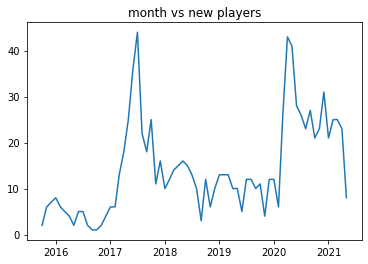

In [74]:
df = pd.read_sql_query("""
    SELECT 
        date(timestamp, "start of month") as month,
        count(distinct name) as n
    FROM levels
    WHERE level = 2
    group by 1
""", conn)
df["month"] = pd.to_datetime(df.month)
plt.plot(df.month, df.n)
plt.title("month vs new players")

In [75]:
df.sort_values("n", ascending=False).head()

,month,n
21,2017-07-01,44
54,2020-04-01,43
55,2020-05-01,41
20,2017-06-01,36
62,2020-12-01,31


In [76]:
df[df.n == df.n.median()]

,month,n
28,2018-02-01,12
36,2018-10-01,12
45,2019-07-01,12
46,2019-08-01,12
50,2019-12-01,12
51,2020-01-01,12


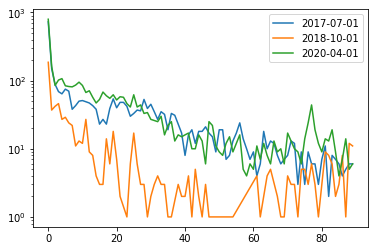

In [85]:
df = pd.read_sql_query("""
    with cohort as (
        select
            name,
            min(timestamp) as starting_ts,
            date(min(timestamp), "start of month") as starting_month
        from levels
        where level = 2
        group by 1
    ),
    days as (
        select 
            starting_month,
            cast((
                julianday(timestamp)-julianday(starting_ts)
            ) as integer) as difference,
            count(*) as n_levels
        from levels
        join cohort
        using (name)
        where starting_month in ("2017-07-01", "2020-04-01", "2018-10-01")
        group by 1, 2
        order by 1, 2
    )
    select * from days where difference < 90
""", conn)
df

for month in df.starting_month.unique():
    s = df[df.starting_month == month]
    plt.plot(s.difference, s.n_levels, label=f"{month}")
plt.legend()
plt.yscale("log")
plt.show()

In [140]:
df = pd.read_sql_query("""
    -- cohorts are people who started in the same month
    with cohort as (
        select
            name,
            min(timestamp) as starting_ts,
            date(min(timestamp), "start of month") as starting_month
        from levels
        where level = 2
        group by 1
    ),
    -- we'll only look at 90 days after people start playing
    day_range as (
            select 0 day 
        union 
            select day + 1 
            from day_range 
            where day <= 90
    ),
    -- we take a look at mid-2017, beginning of 2020, and a median date
    selected_cohort as (
        select distinct
            starting_month,
            name,
            cast(julianday(timestamp)-julianday(starting_ts) as integer) as difference,
            level
        from levels
        join cohort
        using (name)
        where starting_month in ("2017-07-01", "2020-04-01", "2018-10-01")
    ),
    -- many players will level more than once in a day, so choose the level on the day boundary
    level_at_day as (
        select
            starting_month,
            name,
            day,
            max(level) over (
                partition by starting_month, name
                order by level
                rows 1 preceding
            ) as level
        from day_range
        cross join selected_cohort
        where difference <= day
    ),
    -- get the max level for each day, this one in particularly interesting for other analysis
    max_level_at_day as (
        select
            starting_month,
            name,
            day,
            max(level) as level
        from level_at_day
        group by 1, 2, 3
    )
    select
        *
    from
        max_level_at_day
""", conn)
df

,starting_month,name,day,level
0,2017-07-01,AisKosong,0,12
1,2017-07-01,AisKosong,1,12
2,2017-07-01,AisKosong,2,12
3,2017-07-01,AisKosong,3,12
4,2017-07-01,AisKosong,4,12
...,...,...,...,...
9103,2020-04-01,xfce,87,108
9104,2020-04-01,xfce,88,108
9105,2020-04-01,xfce,89,110
9106,2020-04-01,xfce,90,113


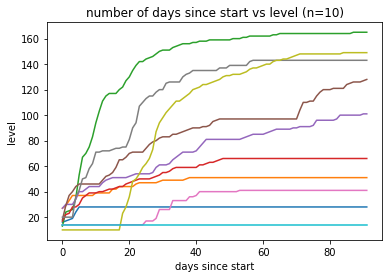

In [147]:
for name in pd.Series(df.name.unique()).sample(10):
    s = df[df.name == name]
    plt.plot(s.day, s.level)
plt.title("number of days since start vs level (n=10)")
plt.xlabel("days since start")
plt.ylabel("level")
plt.show()

In [148]:
df = pd.read_sql_query("""
    -- cohorts are people who started in the same month
    with cohort as (
        select
            name,
            min(timestamp) as starting_ts,
            date(min(timestamp), "start of month") as starting_month
        from levels
        where level = 2
        group by 1
    ),
    -- we'll only look at 90 days after people start playing
    day_range as (
            select 0 day 
        union 
            select day + 1 
            from day_range 
            where day <= 90
    ),
    -- we take a look at mid-2017, beginning of 2020, and a median date
    selected_cohort as (
        select distinct
            starting_month,
            name,
            cast(julianday(timestamp)-julianday(starting_ts) as integer) as difference,
            level
        from levels
        join cohort
        using (name)
        where starting_month in ("2017-07-01", "2020-04-01", "2018-10-01")
    ),
    -- many players will level more than once in a day, so choose the level on the day boundary
    level_at_day as (
        select
            starting_month,
            name,
            day,
            max(level) over (
                partition by starting_month, name
                order by level
                rows 1 preceding
            ) as level
        from day_range
        cross join selected_cohort
        where difference <= day
    ),
    -- get the max level for each day, this one in particularly interesting for other analysis
    max_level_at_day as (
        select
            starting_month,
            name,
            day,
            max(level) as level
        from level_at_day
        group by 1, 2, 3
    )
    select 
        starting_month,
        day,
        sum(level) as sum_level,
        avg(level) as avg_level
    from max_level_at_day
    group by 1, 2
    order by 1, 2
""", conn)
df

,starting_month,day,sum_level,avg_level
0,2017-07-01,0,774,17.590909
1,2017-07-01,1,924,21.000000
2,2017-07-01,2,1012,23.000000
3,2017-07-01,3,1081,24.568182
4,2017-07-01,4,1145,26.022727
...,...,...,...,...
271,2020-04-01,87,3617,84.116279
272,2020-04-01,88,3622,84.232558
273,2020-04-01,89,3628,84.372093
274,2020-04-01,90,3638,84.604651


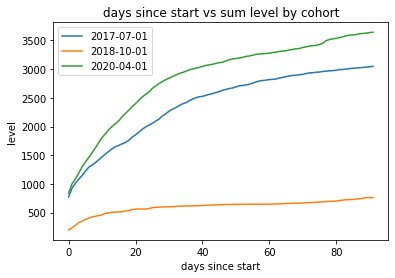

In [152]:
for month in df.starting_month.unique():
    s = df[df.starting_month == month]
    plt.plot(s.day, s.sum_level, label=f"{month}")
plt.legend()
plt.title("days since start vs sum level by cohort")
plt.xlabel("days since start")
plt.ylabel("level")
plt.show()

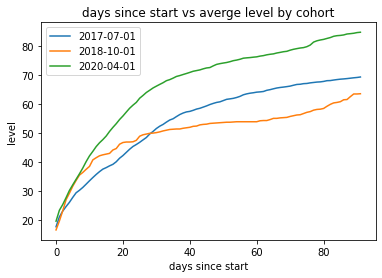

In [153]:
for month in df.starting_month.unique():
    s = df[df.starting_month == month]
    plt.plot(s.day, s.avg_level, label=f"{month}")
plt.legend()
plt.title("days since start vs averge level by cohort")
plt.xlabel("days since start")
plt.ylabel("level")
plt.show()